In [67]:
import os
import mido
import pretty_midi
import random

import numpy as np
from matplotlib import pyplot as plt
from scipy.spatial.distance import cosine, euclidean

from rich.progress import track

random.seed(1)

In [68]:
def plot_metric(pr, metric, title) -> None:
    metric_hist, bins = np.histogram(metric, bins=20, range=(0, 340))
    plt.style.use("dark_background")

    plt.figure(figsize=(12, 6))
    plt.suptitle(title)

    plt.subplot(1, 2, 1)
    plt.imshow(pr, aspect="auto", origin="lower", cmap="magma")
    plt.title("piano roll")
    plt.xlabel("time (s)")
    plt.ylabel("MIDI note number")

    plt.subplot(1, 2, 2)
    plt.hist(bins[:-1], bins, weights=metric_hist)
    plt.title("energy metric")
    plt.xlabel("energy")
    plt.ylabel("magnitude")

    plt.tight_layout()
    plt.show()

In [69]:
dataset = os.path.join("..", "inputs", "all-fourbar")

print(len(os.listdir(dataset)))

24492


In [70]:
def calc_energy(midi):
    envelope_length = 10  # seconds
    energies = []
    for instrument in midi.instruments:
        for note in instrument.notes:
            note_duration = note.end - note.start
            energy = note.velocity * envelope_length / 2

            if note_duration < envelope_length:
                energy = energy - (
                    (envelope_length - note_duration) * note.velocity / 2
                )

            # print(f"{note_duration:04.02f}s * {note.velocity} -> {energy:05.02f}")

            energies.append(energy)

    return energies

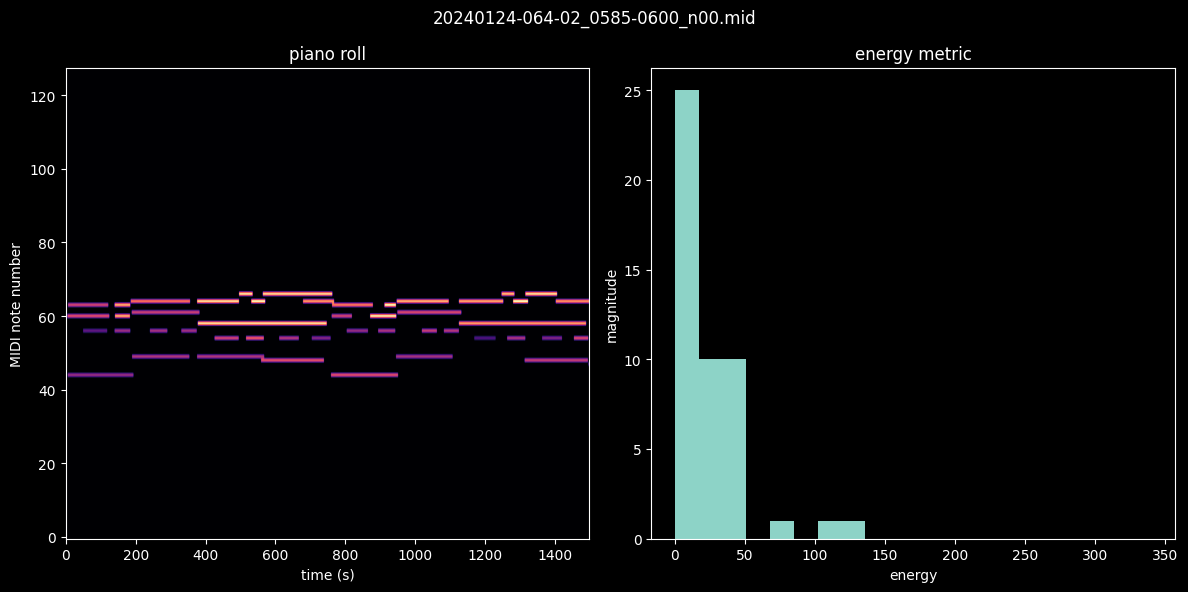

Output()

In [71]:
all_files = os.listdir(dataset)
random.shuffle(all_files)

main_file = os.listdir(dataset)[0]
main_base_file = main_file.split("_")[0]
main_midi_path = os.path.join(dataset, main_file)
midi_pm = pretty_midi.PrettyMIDI(main_midi_path)
main_energy = calc_energy(midi_pm)
main_ph = midi_pm.get_pitch_class_histogram()
main_energy_hist, _ = np.histogram(main_energy, bins=20, range=(0, 340))

plot_metric(midi_pm.get_piano_roll(), main_energy, main_file)

top_ten_cs = [
    ["None", 0.0],
    ["None", 0.0],
    ["None", 0.0],
    ["None", 0.0],
    ["None", 0.0],
    ["None", 0.0],
    ["None", 0.0],
    ["None", 0.0],
    ["None", 0.0],
    ["None", 0.0],
]
top_ten_eu = [
    ["None", 0.0],
    ["None", 0.0],
    ["None", 0.0],
    ["None", 0.0],
    ["None", 0.0],
    ["None", 0.0],
    ["None", 0.0],
    ["None", 0.0],
    ["None", 0.0],
    ["None", 0.0],
]
for test_midi_file in track(os.listdir(dataset)):
    # for test_midi_file in os.listdir(dataset):
    test_base_file = test_midi_file.split("_")[0]
    if main_base_file == test_base_file:
        # print(f"skipping {main_file} -> {test_midi_file}")
        continue

    test_midi_path = os.path.join(dataset, test_midi_file)
    midi_pm = pretty_midi.PrettyMIDI(test_midi_path)
    energy = calc_energy(midi_pm)
    energies_hist, _ = np.histogram(energy, bins=20, range=(0, 340))

    # check cosine distance
    sim_cs = 1 - cosine(main_energy_hist, energies_hist)
    smallest_value = float("inf")
    smallest_index = None
    for i, (filename, sim) in enumerate(top_ten_cs):
        added_base_files = [afn.split("_")[0] for afn, s in top_ten_cs]
        if (
            sim < sim_eu
            and sim < smallest_value
            and test_base_file not in added_base_files
        ):
            # print(f"replacing {filename.split('_')[0]} with {test_base_file}")
            smallest_value = sim
            smallest_index = i
    if smallest_index is not None:
        top_ten_cs[smallest_index] = [test_midi_file, sim_cs]

    # check euclidean distance
    sim_eu = 1 / (euclidean(main_energy_hist, energies_hist) + 1e-5)
    smallest_value = float("inf")
    smallest_index = None
    for i, (filename, sim) in enumerate(top_ten_eu):
        added_base_files = [afn.split("_")[0] for afn, s in top_ten_eu]
        if (
            sim < sim_eu
            and sim < smallest_value
            and test_base_file not in added_base_files
        ):
            # print(f"replacing {filename.split('_')[0]} with {test_base_file}")
            smallest_value = sim
            smallest_index = i
    if smallest_index is not None:
        top_ten_eu[smallest_index] = [test_midi_file, sim_eu]

In [72]:
print(top_ten_cs)
print(top_ten_eu)

[['20240123-070-04_0109-0123_u06.mid', 0.9009597410367147], ['20240122-055-05_0139-0157_d01.mid', 0.9098430743002659], ['20240213-100-05_0297-0307_d02.mid', 0.9000229348617168], ['20240121-070-03_0000-0013_d01.mid', 0.9035695470670357], ['20231227-080-05_0000-0012_d02.mid', 0.896167633454264], ['20231220-080-03_0324-0336_d04.mid', 0.9588701391422926], ['20240121-070-02_0973-0987_d05.mid', 0.8982356135169043], ['20231220-080-02_0324-0336_d02.mid', 0.9489152948871737], ['20231227-080-04_0000-0012_d04.mid', 0.8688100585711449], ['20240227-076-02_0341-0353_u01.mid', 0.9192485431350791]]
[['20231228-072-01_0266-0280_d03.mid', 0.09449102896667688], ['20240117-064-06_0120-0135_d01.mid', 0.1767763827971893], ['20240123-070-04_0836-0850_u04.mid', 0.15075544501649718], ['20240124-064-01_0345-0360_u05.mid', 0.09578253677908374], ['20231220-080-02_0420-0432_d06.mid', 0.11785099130903273], ['20231220-080-03_0324-0336_d04.mid', 0.09284758288170943], ['20240122-055-04_0052-0069_d06.mid', 0.1170410102

In [73]:
new_ttcs = top_ten_cs
for i, (similar_file, similarity) in enumerate(new_ttcs):
    sim_splits = similar_file.split("_")
    loop_name = f"{sim_splits[0]}_{sim_splits[1]}"
    ph = pretty_midi.PrettyMIDI(
        os.path.join(dataset, similar_file)
    ).get_pitch_class_histogram()
    sim_ph = 1 - cosine(main_ph, ph)

    for test_midi_file in os.listdir(dataset):
        new_splits = test_midi_file.split("_")
        new_loop_name = f"{new_splits[0]}_{new_splits[1]}"
        new_ph = pretty_midi.PrettyMIDI(
            os.path.join(dataset, test_midi_file)
        ).get_pitch_class_histogram()

        new_sim_ph = 1 - cosine(main_ph, new_ph)

        if loop_name == new_loop_name and new_sim_ph > sim_ph:
            print(
                f"found greater sim in transposition: {test_midi_file} ({new_sim_ph:.03f}) > {similar_file} ({sim_ph:.03f})"
            )
            top_ten_cs[i] = [test_midi_file, similarity]

            # calculate new sim
            sim_ph = 1 - cosine(main_ph, new_ph)

print(new_ttcs)

found greater sim in transposition: 20240123-070-04_0109-0123_u05.mid (0.533) > 20240123-070-04_0109-0123_u06.mid (0.483)
found greater sim in transposition: 20240123-070-04_0109-0123_u01.mid (0.881) > 20240123-070-04_0109-0123_u06.mid (0.533)
found greater sim in transposition: 20240213-100-05_0297-0307_d03.mid (0.554) > 20240213-100-05_0297-0307_d02.mid (0.350)
found greater sim in transposition: 20240213-100-05_0297-0307_d01.mid (0.798) > 20240213-100-05_0297-0307_d02.mid (0.554)
found greater sim in transposition: 20240121-070-03_0000-0013_u01.mid (0.740) > 20240121-070-03_0000-0013_d01.mid (0.705)
found greater sim in transposition: 20231227-080-05_0000-0012_d03.mid (0.484) > 20231227-080-05_0000-0012_d02.mid (0.384)
found greater sim in transposition: 20231227-080-05_0000-0012_d01.mid (0.620) > 20231227-080-05_0000-0012_d02.mid (0.484)
found greater sim in transposition: 20231227-080-05_0000-0012_d04.mid (0.742) > 20231227-080-05_0000-0012_d02.mid (0.620)
found greater sim in tra

In [74]:
new_tteu = top_ten_eu
for i, (similar_file, similarity) in enumerate(new_tteu):
    sim_splits = similar_file.split("_")
    loop_name = f"{sim_splits[0]}_{sim_splits[1]}"
    ph = pretty_midi.PrettyMIDI(
        os.path.join(dataset, similar_file)
    ).get_pitch_class_histogram()
    sim_ph = 1 - cosine(main_ph, ph)

    for test_midi_file in os.listdir(dataset):
        new_splits = test_midi_file.split("_")
        new_loop_name = f"{new_splits[0]}_{new_splits[1]}"
        new_ph = pretty_midi.PrettyMIDI(
            os.path.join(dataset, test_midi_file)
        ).get_pitch_class_histogram()

        new_sim_ph = 1 - cosine(main_ph, new_ph)

        if loop_name == new_loop_name and new_sim_ph > sim_ph:
            print(
                f"found greater sim in transposition: {test_midi_file} ({new_sim_ph:.03f}) > {similar_file} ({sim_ph:.03f})"
            )
            top_ten_cs[i] = [test_midi_file, similarity]

            # calculate new sim
            sim_ph = 1 - cosine(main_ph, new_ph)
print(new_tteu)

found greater sim in transposition: 20231228-072-01_0266-0280_d01.mid (0.746) > 20231228-072-01_0266-0280_d03.mid (0.477)
found greater sim in transposition: 20240117-064-06_0120-0135_u01.mid (0.863) > 20240117-064-06_0120-0135_d01.mid (0.809)
found greater sim in transposition: 20240123-070-04_0836-0850_u06.mid (0.737) > 20240123-070-04_0836-0850_u04.mid (0.641)
found greater sim in transposition: 20240124-064-01_0345-0360_u06.mid (0.529) > 20240124-064-01_0345-0360_u05.mid (0.043)
found greater sim in transposition: 20240124-064-01_0345-0360_u04.mid (0.736) > 20240124-064-01_0345-0360_u05.mid (0.529)
found greater sim in transposition: 20231220-080-02_0420-0432_d04.mid (0.827) > 20231220-080-02_0420-0432_d06.mid (0.810)
found greater sim in transposition: 20231220-080-03_0324-0336_d06.mid (0.664) > 20231220-080-03_0324-0336_d04.mid (0.469)
found greater sim in transposition: 20231220-080-03_0324-0336_u04.mid (0.960) > 20231220-080-03_0324-0336_d04.mid (0.664)
found greater sim in tra

playing ../inputs/all-fourbar/20240124-064-02_0585-0600_n00.mid


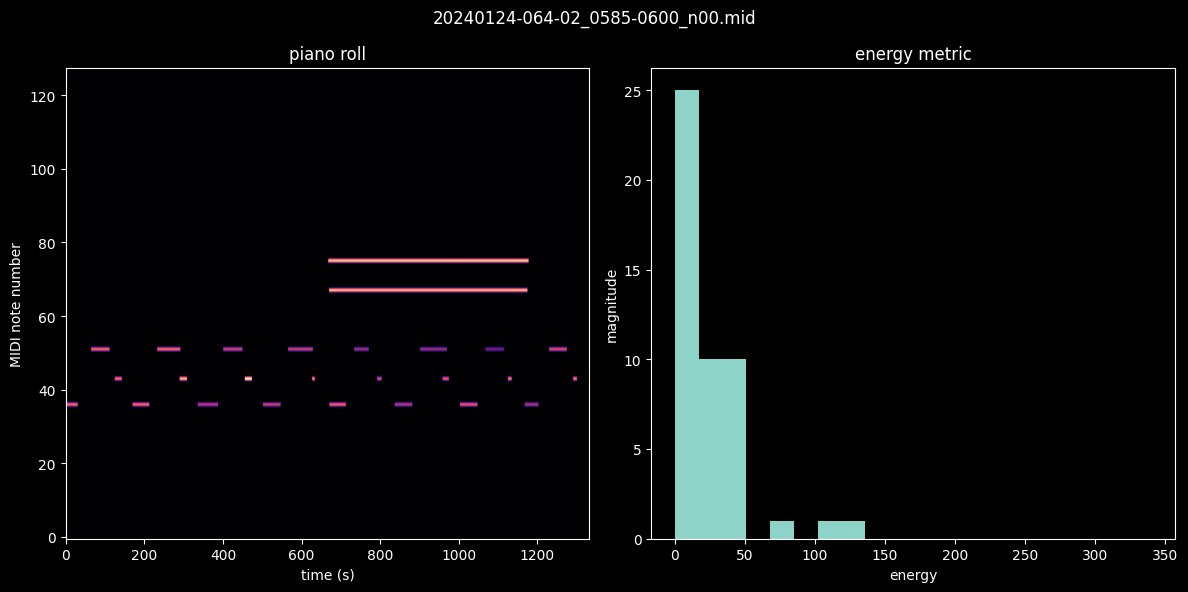

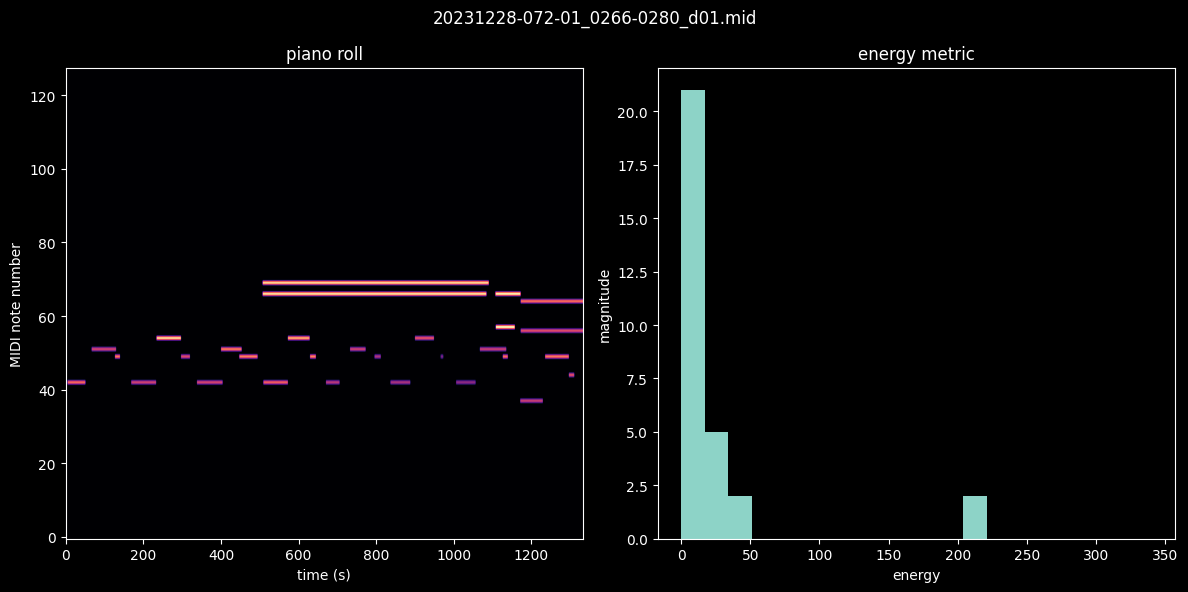

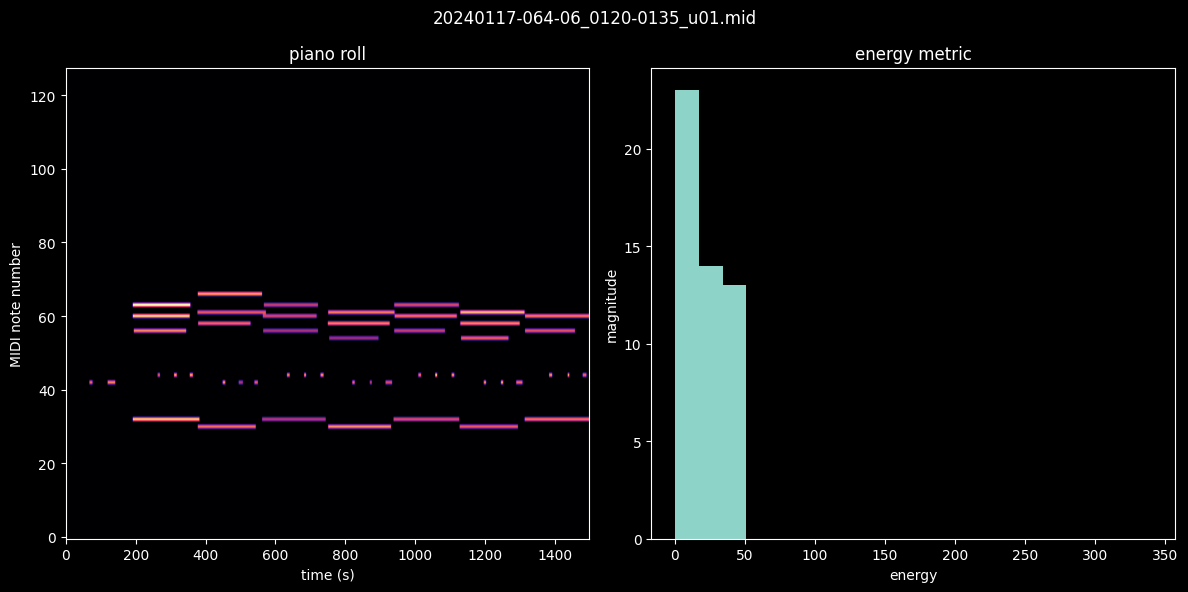

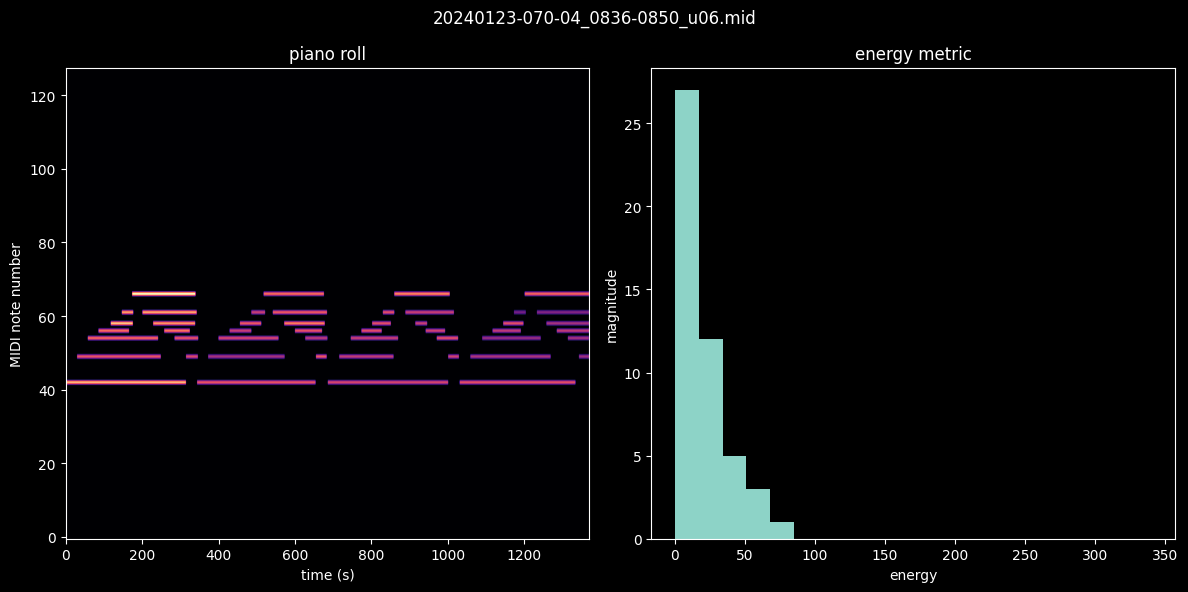

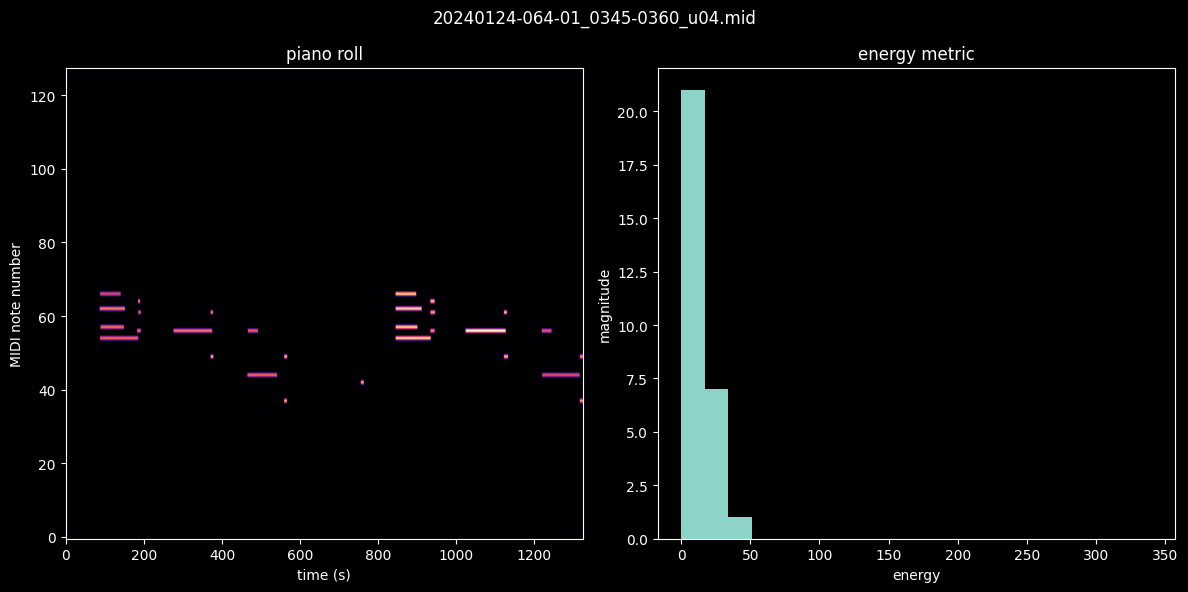

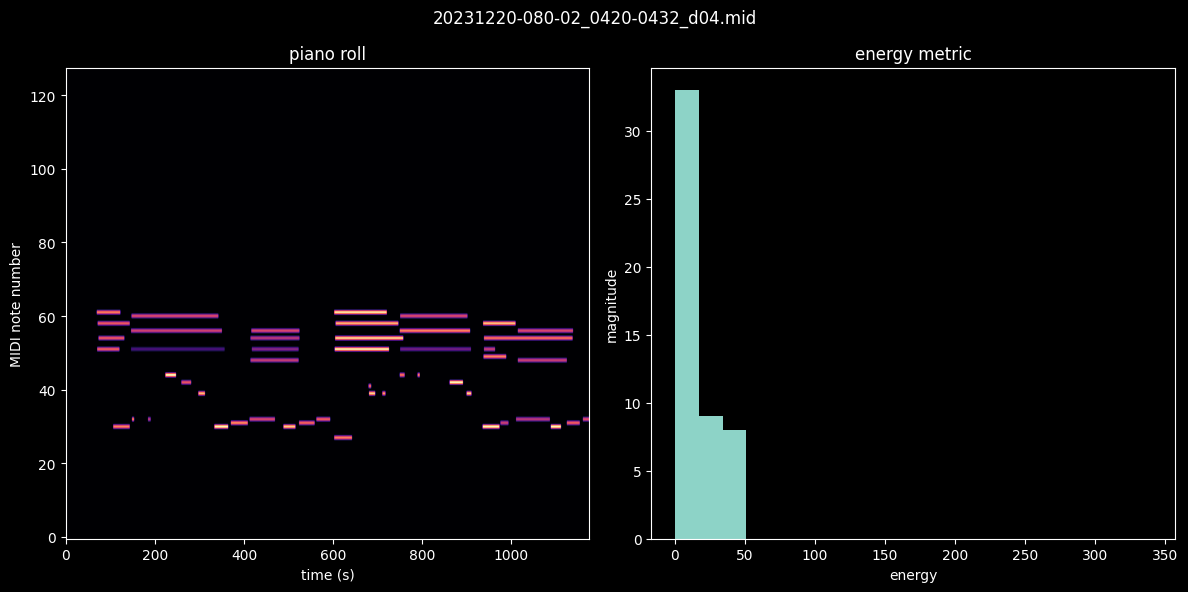

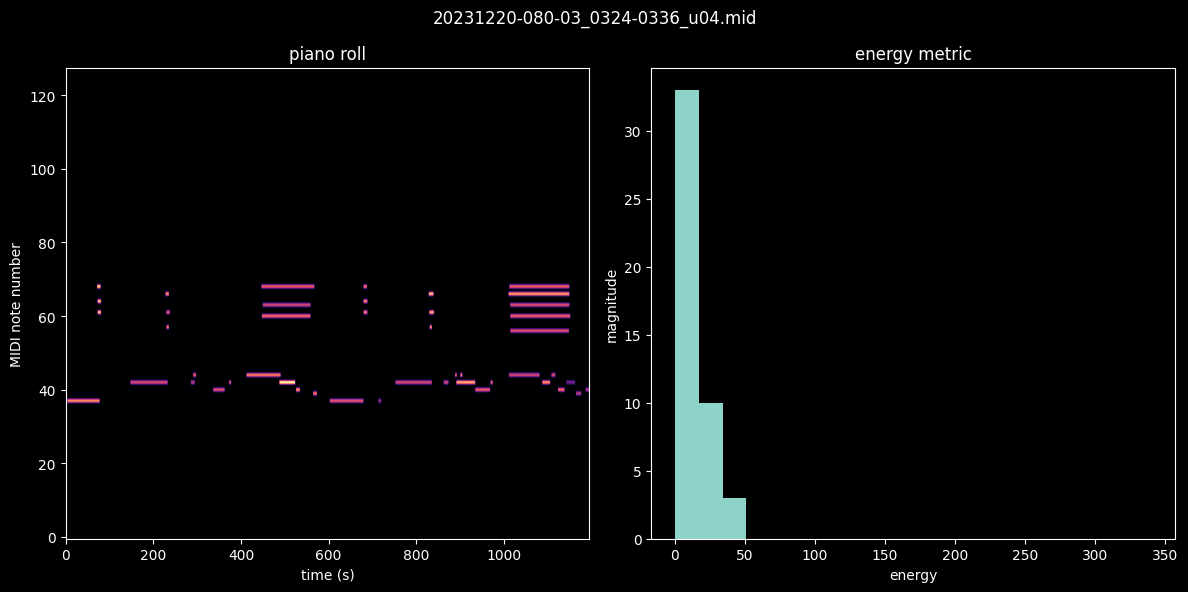

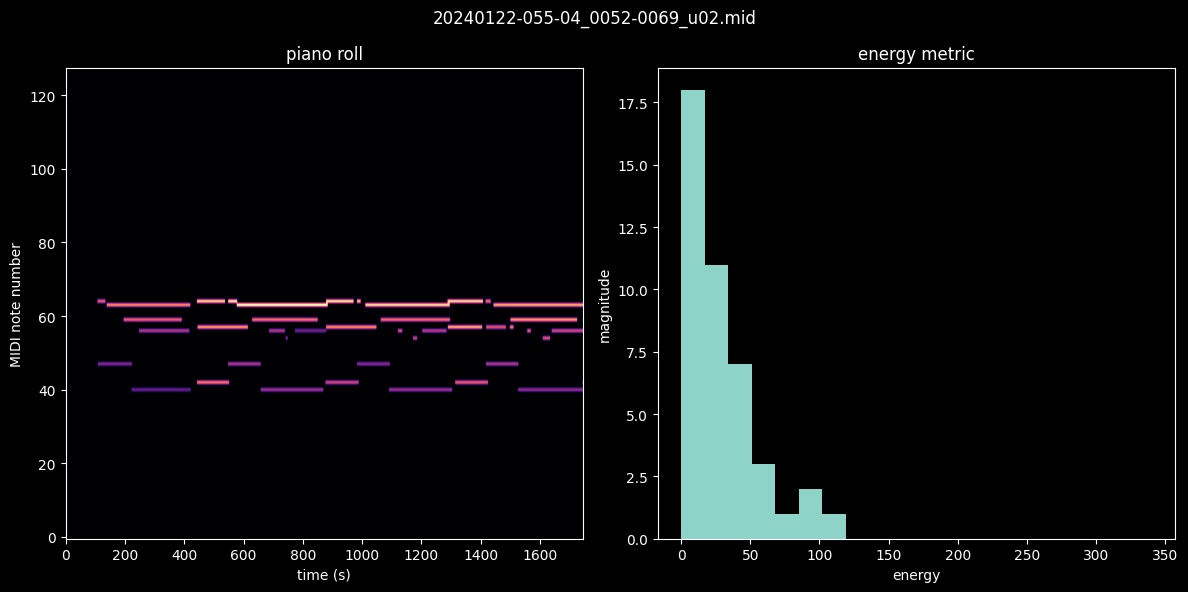

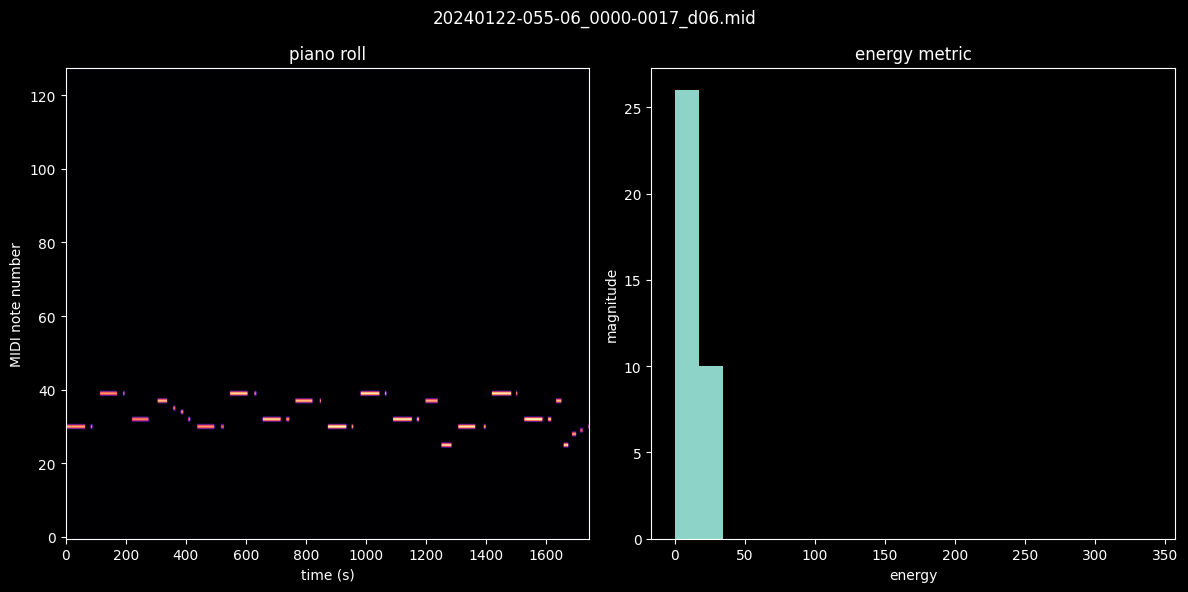

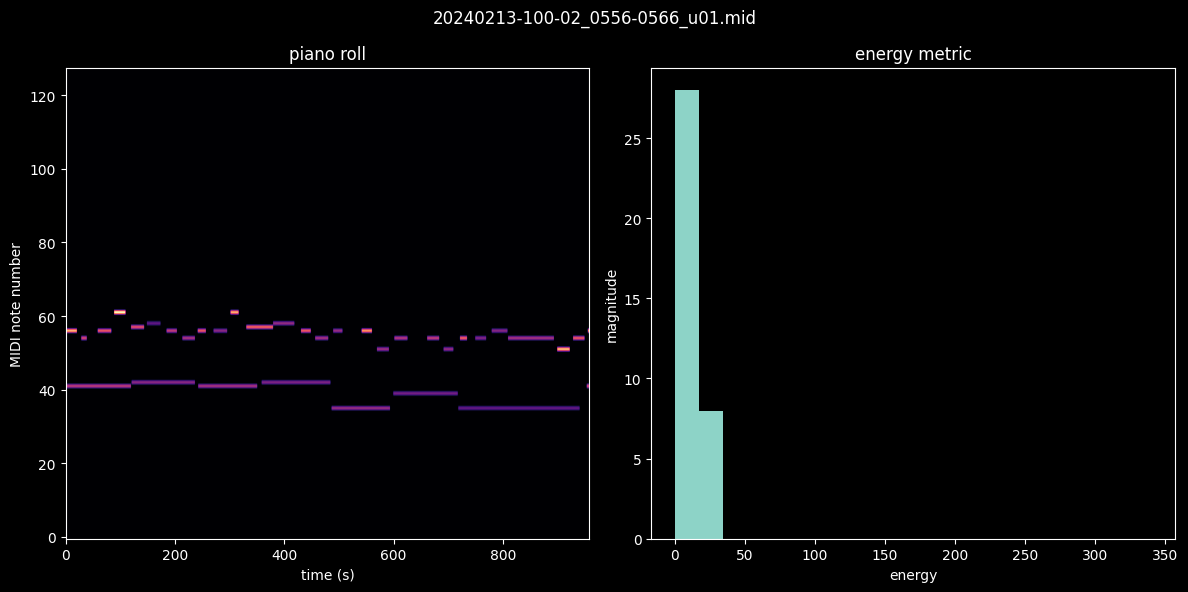

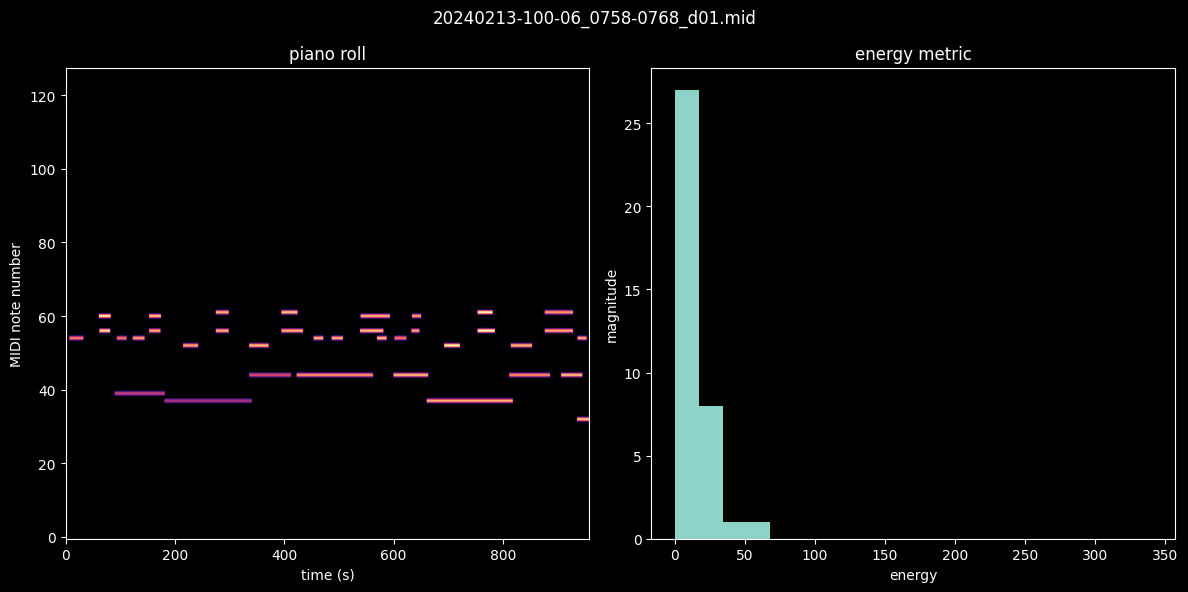

In [78]:
energy = calc_energy(midi_pm)
energies_hist, _ = np.histogram(energy, bins=20, range=(0, 340))
plot_metric(midi_pm.get_piano_roll(), main_energy, main_file)

with mido.open_output("Disklavier") as output:  # type: ignore
    for message in mido.MidiFile(main_midi_path).play():
        output.send(message)

for file, sim in new_ttcs:
    fp = os.path.join(dataset, file)
    
    playing_pm = pretty_midi.PrettyMIDI(fp)
    playing_energy = calc_energy(playing_pm)
    playing_ph = playing_pm.get_pitch_class_histogram()
    playing_energy_hist, _ = np.histogram(playing_energy, bins=20, range=(0, 340))
    plot_metric(playing_pm.get_piano_roll(), playing_energy, file)

    with mido.open_output("Disklavier") as output:  # type: ignore
        for message in mido.MidiFile(fp).play():
            output.send(message)

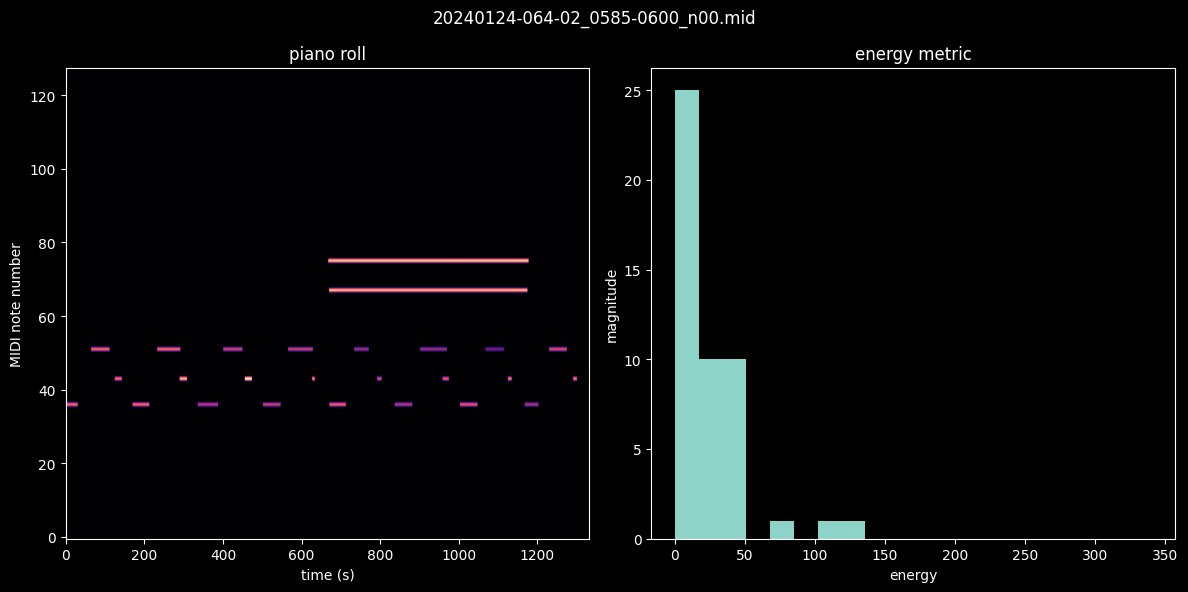

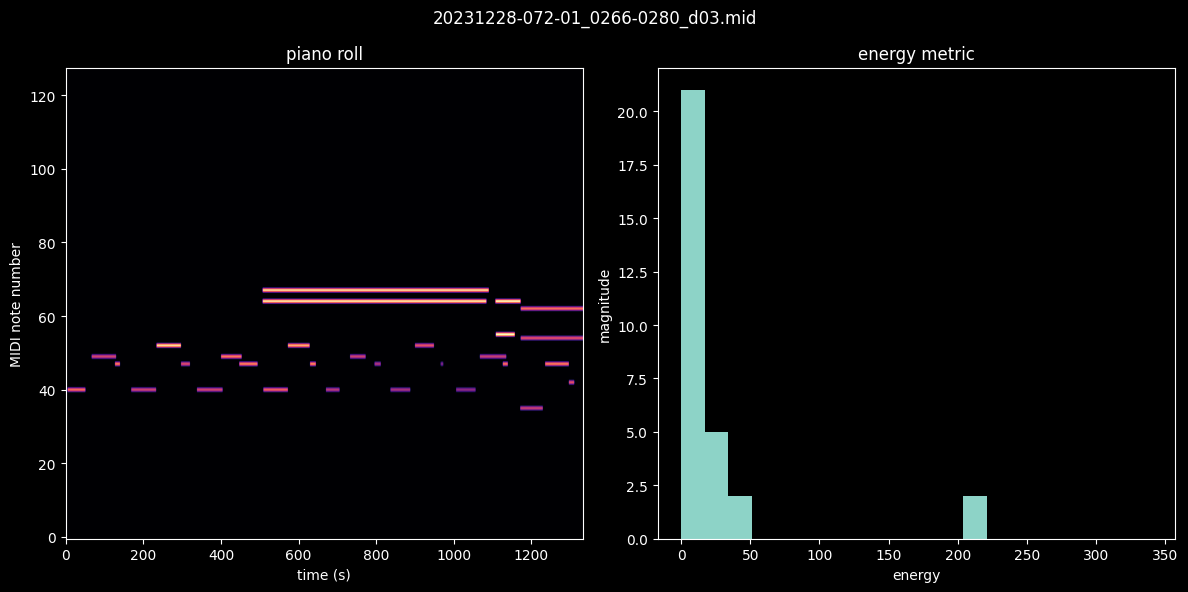

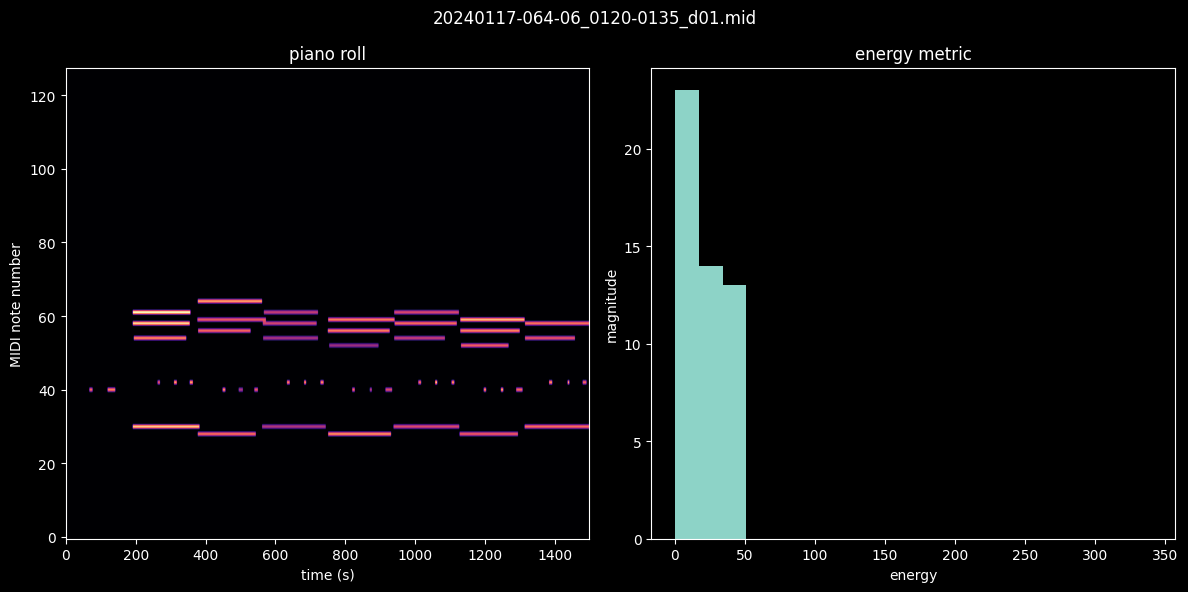

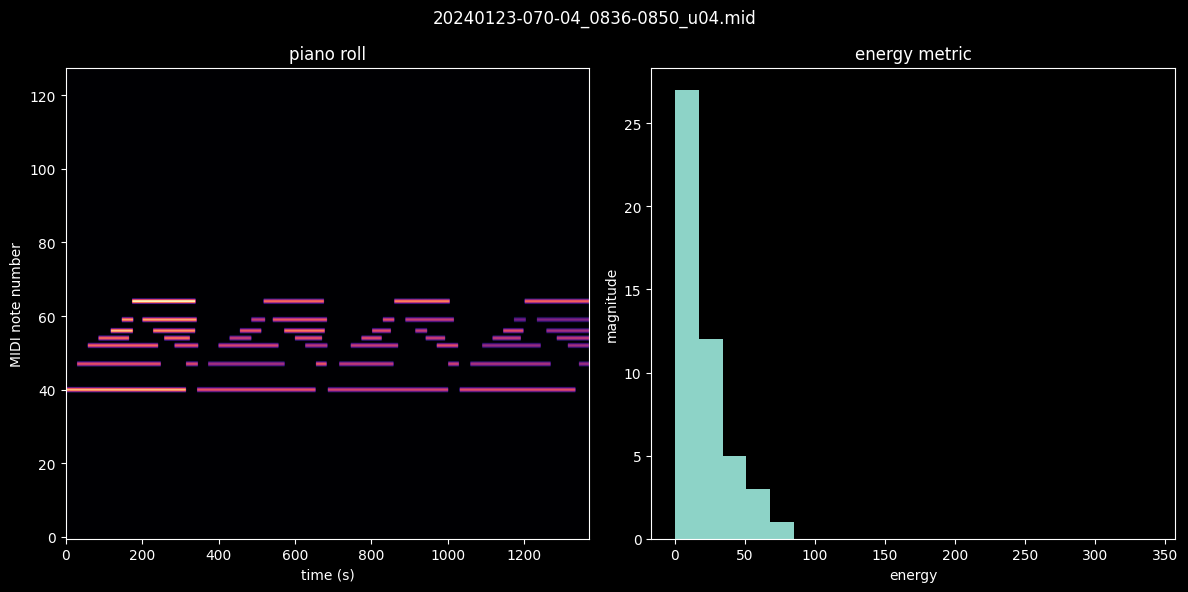

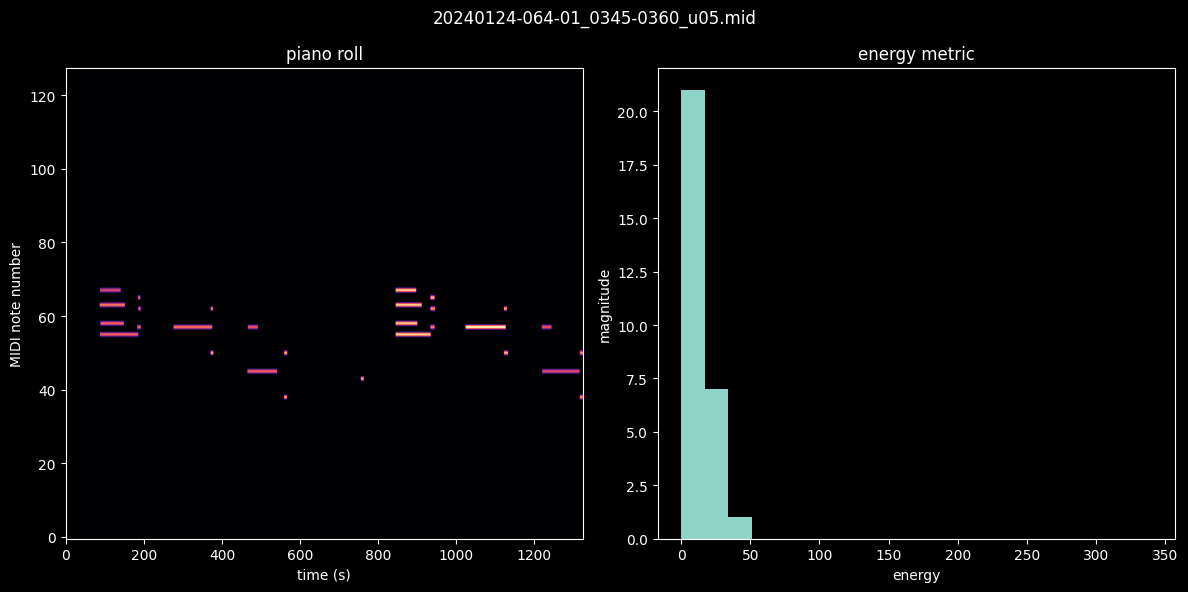

KeyboardInterrupt: 

In [79]:
energy = calc_energy(midi_pm)
energies_hist, _ = np.histogram(energy, bins=20, range=(0, 340))
plot_metric(midi_pm.get_piano_roll(), main_energy, main_file)

with mido.open_output("Disklavier") as output:  # type: ignore
    for message in mido.MidiFile(main_midi_path).play():
        output.send(message)

for file, sim in new_tteu:
    fp = os.path.join(dataset, file)

    playing_pm = pretty_midi.PrettyMIDI(fp)
    playing_energy = calc_energy(playing_pm)
    playing_ph = playing_pm.get_pitch_class_histogram()
    playing_energy_hist, _ = np.histogram(playing_energy, bins=20, range=(0, 340))
    plot_metric(playing_pm.get_piano_roll(), playing_energy, file)

    with mido.open_output("Disklavier") as output:  # type: ignore
        for message in mido.MidiFile(fp).play():
            output.send(message)